## Figure 1

Normality scores, decision threshold, and receiver operating characteristic (ROC) curve.  

In [2]:
import LocalEnv
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import metrics 
from JAMA_config import *

from scripts.LabTestAnalysis.lab_statistics import stats_utils
from scripts.LabTestAnalysis.machine_learning.ml_utils import map_lab

import warnings
warnings.filterwarnings("always")

In [3]:
lab = 'LABLDH'
data_source = 'Stanford'
lab_type = 'panel'
score_thres = 0.756
include_threshold_colors = True

dataSet_foldername = 'data-%s-%s-%s'%(data_source, 
                                      lab_type, 
                                      curr_version)
dataML_folderpath = os.path.join(ML_folderpath, dataSet_foldername)
dataStats_folderpath = os.path.join(stats_folderpath, dataSet_foldername)

labDescriptions = stats_utils.get_lab_descriptions(data_source=data_source, 
                                                   lab_type=lab_type)

In [4]:
figure1_folderpath = os.path.join(stats_folderpath, 'Fig1_cartoon')
if not os.path.exists(figure1_folderpath):
    os.mkdir(figure1_folderpath)

xVal_base, yVal_base, score_base, xVal_best, yVal_best, score_best, p_val \
            = stats_utils.get_curve_onelab(lab,
                                           all_algs=['random-forest'],
                                           data_folder=dataML_folderpath,
                                           curve_type='ROC',
                                           get_pval=False)

### (a) Histogram of normality scores distributed among normal (black) and abnormal (grey) orders.

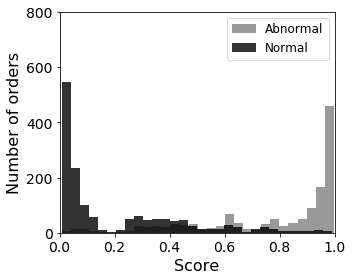

<Figure size 432x288 with 0 Axes>

In [8]:
figure, ax = plt.subplots(figsize=(5, 4))
alg = 'random-forest'
df = pd.read_csv(dataML_folderpath + "/%s/%s/direct_comparisons.csv"
                 % (lab, alg), keep_default_na=False)

df1 = pd.read_csv(dataML_folderpath + "/%s/%s/%s-normality-prediction-%s-report.tab"
                  % (lab, alg, lab, alg), sep='\t', keep_default_na=False)
auc = df1['roc_auc'].values[0]

scores_actual_0 = df[df['actual'] == 0]['predict'].values
scores_actual_1 = df[df['actual'] == 1]['predict'].values

if not inverse01:
    plt.hist(scores_actual_0, bins=30, alpha=0.8, color='gray', label="Abnormal") #gray red
    plt.hist(scores_actual_1, bins=30, alpha=0.8, color='black', label="Normal") #black green
else:
    plt.hist(1-scores_actual_0, bins=30, alpha=0.8, color='gray', label="Abnormal")
    plt.hist(1-scores_actual_1, bins=30, alpha=0.8, color='black', label="Normal")

plt.legend(fontsize=12)

plt.xlim([0, 1])
plt.ylim([0, 800])
# plt.xticks([])
# plt.yticks([])
# plt.xlabel(lab_descriptions[lab])
# plt.xlabel('random forest', fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Number of orders', fontsize=16)

ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(figure1_folderpath, 'cartoon_%s%s.png' % (lab, inverse_maker)))
plt.clf()

### (b) After picking a threshold, orders are classified into “predicted normal” if their normality scores fall above the threshold or “predicted abnormal” if falling below the threshold. Further, true negative orders (green) are both “predicted normal” and actually normal, false negative orders (red) are “predicted normal” and actually abnormal, false positive orders (yellow) are “predicted abnormal” and actually normal, and true positive orders (blue) are both “predicted abnormal” and actually abnormal. 

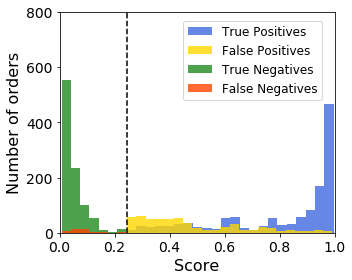

<Figure size 432x288 with 0 Axes>

In [12]:


df = pd.read_csv(dataML_folderpath + "/%s/baseline_comparisons.csv"
                 % (lab), keep_default_na=False)
scores_actual_0 = df[df['actual'] == 0]['predict'].values
scores_actual_1 = df[df['actual'] == 1]['predict'].values

plot_baseline = False
if plot_baseline:
    plt.figure(figsize=(5, 4))


    plt.hist(scores_actual_0, bins=30, alpha=0.8, color='b', label="Abnormal")
    plt.hist(scores_actual_1, bins=30, alpha=0.8, color='g', label="Normal")
    plt.xlim([0, 1])
    plt.ylim([0, 500])
    plt.xticks([])
    plt.yticks([])
    # plt.xlabel(lab_descriptions[lab] + 'auroc=%.2f' % auc)
    # plt.xlabel('baseline', fontsize=16)
    plt.xlabel('Score, baseline', fontsize=16)
    plt.ylabel('num of orders', fontsize=16)
    plt.legend(fontsize=12)
    plt.savefig(os.path.join(figure1_folderpath, 'cartoon_baseline_%s.png'%lab))
    plt.clf()

figure, ax = plt.subplots(figsize=(5, 4))
alg = 'random-forest'
df = pd.read_csv(dataML_folderpath + "/%s/%s/direct_comparisons.csv"
                 % (lab, alg), keep_default_na=False)

df1 = pd.read_csv(dataML_folderpath + "/%s/%s/%s-normality-prediction-%s-report.tab"
                  % (lab, alg, lab, alg), sep='\t', keep_default_na=False)
auc = df1['roc_auc'].values[0]

scores_actual_trueNega = df[(df['actual']==0) & (df['predict']<score_thres)]['predict'].values
scores_actual_falsPosi = df[(df['actual'] == 0) & (df['predict'] >= score_thres)]['predict'].values

scores_actual_falsNega = df[(df['actual'] == 1) & (df['predict'] < score_thres)]['predict'].values
scores_actual_truePosi = df[(df['actual'] == 1) & (df['predict'] >= score_thres)]['predict'].values

if not inverse01:
    plt.hist(scores_actual_trueNega, bins=22, alpha=0.8, color='royalblue', label="true negatives")
    plt.hist(scores_actual_falsNega, bins=22, alpha=0.8, color='gold', label="false negatives")
    plt.hist(scores_actual_truePosi, bins=7, alpha=0.8, color='forestgreen', label="true positives")
    plt.hist(scores_actual_falsPosi, bins=7, alpha=0.8, color='orangered', label="false positives")

    plt.plot([score_thres] * dash_num, np.linspace(0, 800, num=dash_num), 'k--')
else:
    plt.hist(1-scores_actual_trueNega, bins=22, alpha=0.8, color='royalblue', label="True Positives")
    plt.hist(1-scores_actual_falsNega, bins=22, alpha=0.8, color='gold', label="False Positives")
    plt.hist(1-scores_actual_truePosi, bins=7, alpha=0.8, color='forestgreen', label="True Negatives")
    plt.hist(1-scores_actual_falsPosi, bins=7, alpha=0.8, color='orangered', label="False Negatives")

    plt.plot([1-score_thres] * dash_num, np.linspace(0, 800, num=dash_num), 'k--')



plt.legend(loc=(0.45,0.6), fontsize=12)

    

plt.xlim([0, 1])
plt.ylim([0, 800])
# plt.xticks([])
# plt.yticks([])
# plt.xlabel(lab_descriptions[lab])
# plt.xlabel('random forest', fontsize=16)
plt.xlabel('Score', fontsize=16)
plt.ylabel('Number of orders', fontsize=16)

ax.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

plt.savefig(os.path.join(figure1_folderpath, 'cartoon_%s_thres%s.png' % (lab, inverse_maker)))
plt.clf()

### (c) This choice of threshold leads to a sensitivity of 96% and specificity of 67% as shown on the ROC curve.

sensitivity 0.636603028308
specificity 0.96447467876
score_thres 0.756


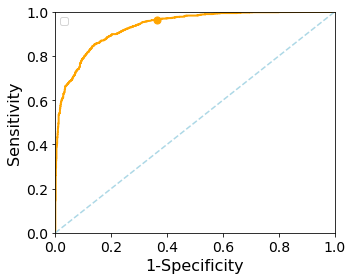

<Figure size 432x288 with 0 Axes>

In [5]:
fig, ax = plt.subplots(figsize=(5, 4))
# plt.plot(xVal_base, yVal_base, label='baseline model, %0.2f' % (score_base), linewidth=2)
'''Representative ROC of LABLDH'''
if not inverse01:
    plt.plot(xVal_best, yVal_best, color='orange', linewidth=2) #, label='Best Alg', label='random forest', AUROC=%0.2f  % (score_best)
else:
    plt.plot(1-yVal_best, 1-xVal_best, color='orange', linewidth=2) #, label='Best Alg'

if include_threshold_colors:
    df_directcompare_rf = pd.read_csv(os.path.join(dataML_folderpath, lab, 'random-forest', 'direct_comparisons.csv'))
    actual_labels = df_directcompare_rf['actual'].values
    predict_probas = df_directcompare_rf['predict'].values

    sensitivity, specificity, LR_p, LR_n, PPV, NPV = stats_utils.get_confusion_metrics(actual_labels, predict_probas, score_thres, also_return_cnts=False)
    print "sensitivity", sensitivity
    print "specificity", specificity
    print "score_thres", score_thres

    '''The POINT of PPV=0.95'''
    if not inverse01:
        plt.scatter(1-specificity, sensitivity, s=50, color='orange')
    else:
        plt.scatter(1-sensitivity, specificity, s=50, color='orange')
        

    '''Reference line of AUC=0.5'''
    dash_num = 20
    # plt.plot([1-specificity]*dash_num, np.linspace(0,1,num=dash_num), 'k--')
    plt.plot(np.linspace(0,1,num=dash_num),np.linspace(0,1,num=dash_num), 
             color='lightblue', linestyle='--'
             #label = 'Baseline'
            )#, )

plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.xticks([])
#plt.yticks([])

plt.ylabel('Sensitivity', fontsize=16) #lab_descriptions.get(lab, lab)
plt.xlabel('1-Specificity', fontsize=16)

ax.tick_params(axis='both', labelsize=14)

plt.legend()
plt.tight_layout()

plt.show()
# plt.legend(fontsize=12)
plt.savefig(os.path.join(figure1_folderpath, 'ROC_%s%s.png'%(lab,inverse_maker)))

plt.clf()